# Handout\#2 - Self-Organizing Maps (SOM)

## Load data

In [1]:
import numpy as np

In [2]:
group = '02'  # Bernat Ladaria, Lluís
ds = 2  # problem 2

input_len = 2  # dimension (number of features)

In [3]:
data_train = np.loadtxt('ds' + group + str(ds) + 'tr.txt')

In [4]:
X_train = data_train[:, 0:input_len]
y_train = data_train[:, input_len]

Check classes

In [5]:
np.unique(y_train)

array([0., 1., 2., 3.])

In [6]:
data_test = np.loadtxt('ds' + group + str(ds) + 'te.txt')

In [7]:
X_test = data_test[:, 0:input_len]
y_test = data_test[:, input_len]

In [8]:
np.unique(y_test)

array([0., 1., 2., 3.])

In [9]:
num_datapoints = len(X_train)
print(num_datapoints)

640


## Training data plot

In [10]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

Create a color map to make easier comparisons

In [11]:
our_colors = ['blue', 'darkorange', 'green', 'darkred']
our_cmap = LinearSegmentedColormap.from_list("mycmap", our_colors)

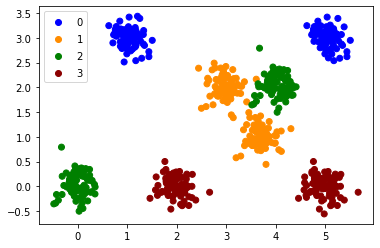

In [12]:
scatter = plt.scatter(x=X_train[:, 0], y=X_train[:, 1], c=y_train, cmap=our_cmap)
plt.legend(*scatter.legend_elements())

## Testing data plot

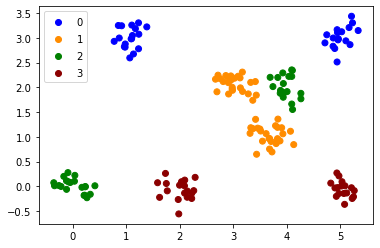

In [13]:
scatter = plt.scatter(x=X_test[:, 0], y=X_test[:, 1], c=y_test, cmap=our_cmap)
plt.legend(*scatter.legend_elements())

## Define the SOM

### SOM cardinality

According to Kohonen’s advice:
$$A = 5 \sqrt{N}$$ 
Where $N$ is the number of samples, $A$ is the number of neurons to use.

In [14]:
A = 5 * (num_datapoints)**(1/2)
A

126.49110640673518

So will use the upper nearest power of 2 to have a beauty number

In [15]:
A = 128

## Using RAW DATA

### Ratio

Now we must determine the ratio from the two largest eigenvalues from covariance matrix

In [16]:
from numpy import (linalg, cov, transpose, argsort)
data = X_train

ev, _ = linalg.eig(cov(transpose(data)))
ev_order = argsort(-ev)

try: 
    ratio = ev[ev_order[0]] / ev[ev_order[1]]
except:
    ratio = 1.

print(ratio)

2.1547363830695208


So, will try to define *N* x *M* rectangle whose sides are a power of 2 and N/M ratio value is near 'ratio'

In [17]:
N = 16
M = A // N

In [18]:
print(f"N={N}, M={M}")

N=16, M=8


### SOM definition

Load class

In [19]:
from minisom import MiniSom

Define a function to create, evaluate and select best trained SOM.

Using these steps:
- Create a SOM object
- Initialize de weights using the two principal components of data (PCA).
- Train SOM. Will use Kohonen's recommendation (1000 iterations).
- Save results.

And finally:
- Select best qE and/or tE.

In [20]:
def eval_and_get_best_som(tries: int, 
                          data:np.ndarray, 
                          N: int, M: int, sigma: float, lr: float, 
                          iterations: int, batch: bool) -> list():
    
    # Will use lists to remember
    soms = list()
    eqs = list()
    ets = list()
    
    for i in range(tries):
        # create new SOM object
        som = MiniSom(x=N, y=M, input_len=data.shape[1],
                      sigma=sigma, learning_rate=lr, 
                      neighborhood_function='gaussian',
                      topology='rectangular',
                      activation_distance='euclidean')
        
        # using the first 2 components of PCA
        som.pca_weights_init(data=data)
        
        # using random picked values from data
        # som.random_weights_init(data=data)
    
        # train and calc errors
        som.train(data=data, num_iteration=iterations, random_order=not batch)
        eq = som.quantization_error(data=data)
        et = som.topographic_error(data=data)
        
        # save results
        soms.append(som)
        eqs.append(eq)
        ets.append(et)
    
    best_som = None
    best_eq = None
    best_et = None
    
    for i in range(tries):
        if best_eq is None or eqs[i] < best_eq:
            best_som = soms[i]
            best_eq = eqs[i]
            best_et = ets[i]

    return best_som, best_eq, best_et

Define a SOM object

In [21]:
sigma = 2
lr = 0.5
iterations = 500 * A  # Kohonen's recommendation

print(iterations)

64000


### Training

#### On-line

In [22]:
[best_som, best_eq_raw, best_et_raw] = eval_and_get_best_som(
    tries=5,
    data=X_train,
    N=N, M=M, sigma=sigma, lr=lr, 
    iterations=iterations, batch=False)

In [23]:
print(f"Best on-line EQ: {best_eq_raw}\nBest on-line ET: {best_et_raw}")

Best on-line EQ: 0.0905980333773165
Best on-line ET: 0.0046875


#### Batch

In [24]:
[batch_som, batch_eq_raw, batch_et_raw] = eval_and_get_best_som(
    tries=1,
    data=X_train,
    N=N, M=M, sigma=sigma, lr=lr, 
    iterations=iterations, batch=True)

In [25]:
print(f"Batch EQ: {batch_eq_raw}\nBatch ET: {batch_et_raw}")

Batch EQ: 0.09161696868620062
Batch ET: 0.0


----

Load matplotlib necessary modules

In [26]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

Define a function to plot a labeled U-matrix (the distance map)

In [27]:
def plot_distance_map(som: object, n_neurons: int, m_neurons: int, 
                      data: np.ndarray, y_true: np.ndarray):
    
    plt.figure(figsize=(0.6*n_neurons, 0.6*m_neurons))

    plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
    plt.colorbar()

    target = y_true.astype(int)
    markers = ['o', 'D', 's', 'p']
    colors = ['C0', 'C1', 'C2', 'C3']
    for cnt, xx in enumerate(data):
        w = som.winner(xx)  # getting the winner
        # palce a marker on the winning position for the sample xx
        plt.plot(w[0]+.5, w[1]+.5, markers[target[cnt]], markerfacecolor='None',
                 markeredgecolor=colors[target[cnt]], markersize=12, markeredgewidth=2)

    plt.show()

Define a function to plot a *pie-styled* class map

In [28]:
def plot_class_map(som: object, n_neurons: int, m_neurons: int, 
                   data: np.ndarray, y_true: np.ndarray):
    
    # Construct class labels
    labels_class = dict([[c, f"w_{c}"] for c in np.unique(y_true).astype(int)])
    
    # Construct neuron set dictionary
    labels_map = som.labels_map(data, [labels_class[t] for t in y_true])
    
    # Will generate N x M pie charts
    fig = plt.figure(figsize=(0.6*n_neurons, 0.6*m_neurons))
    
    the_grid = gridspec.GridSpec(m_neurons, n_neurons, fig)
    
    for position in labels_map.keys():
        label_fracs = [labels_map[position][l] for l in labels_class.values()]
        plt.subplot(the_grid[m_neurons -1 -position[1], position[0]], aspect=1)
        patches, _ = plt.pie(label_fracs)

    fig.legend(patches, labels_class.values(), loc='lower right')
    plt.show()

And define a function to make our best classifying effort 
(almost copy paste from MiniSom library Classification.ipynb notebook)

In [29]:
def classify(som: object, data: np.ndarray, X_train: np.ndarray, y_train: np.ndarray):
    """Classifies each sample in data in one of the classes defined
    using the method labels_map.
    Returns a list of the same length of data where the i-th element
    is the class assigned to data[i].
    """
    winmap = som.labels_map(X_train, y_train)
    default_class = np.sum(list(winmap.values())).most_common()[0][0]
    result = []
    for d in data:
        win_position = som.winner(d)
        if win_position in winmap:
            result.append(winmap[win_position].most_common()[0][0])
        else:
            result.append(default_class)
    return result

Also, for CM printing

In [30]:
def pretty_print_cm(cm: np.ndarray):
    line = '          '
    for j in range(0, cm.shape[1]):
        line = line + (' Predict {:1}'.format(j))
    print(line)
    for i, row in enumerate(cm):
        line = 'Class {:1}: '.format(i) + ''.join(''.join(['{:10}'.format(element) for element in row]))
        print(line)

### U-matrix and class map plots

#### On-line

The below plot is the *on-line* SOM U-matrix representation using non-normalized data

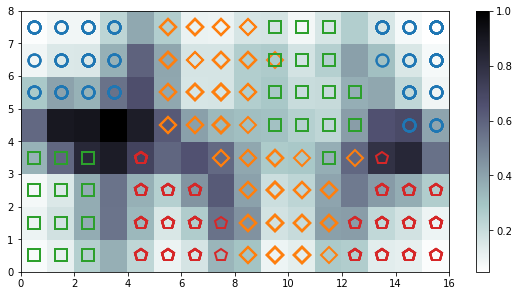

In [31]:
plot_distance_map(best_som, N, M, X_train, y_train)

This is the best *on-line* SOM class map using non-normalized data

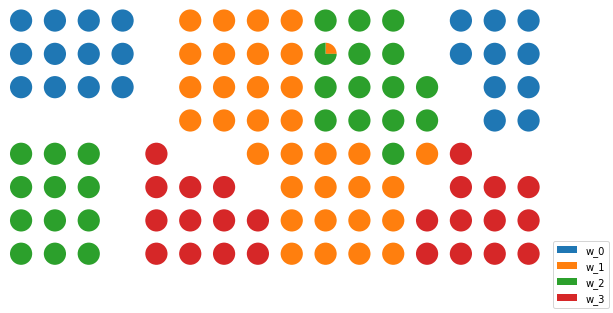

In [32]:
plot_class_map(best_som, N, M, X_train, y_train)

#### Batch

The below plot is the *batch* SOM U-matrix representation using non-normalized data

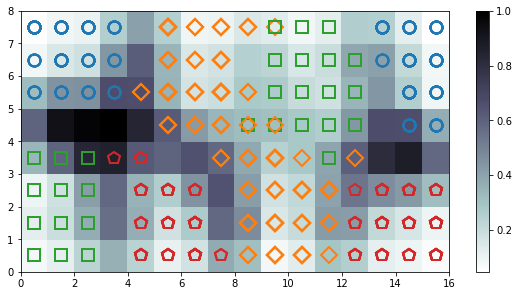

In [33]:
plot_distance_map(batch_som, N, M, X_train, y_train)

The plot below represents the batch SOM class map using non normalized data.

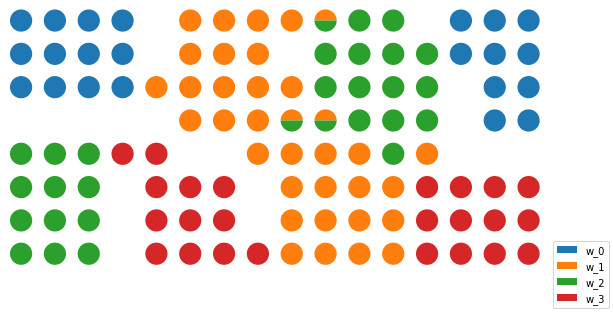

In [34]:
plot_class_map(batch_som, N, M, X_train, y_train)

In [35]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

### Confusion matrix and classification accuracy

#### On-line

In [36]:
y_pred = classify(best_som, X_test, X_train, y_train)

Confusion Matrix:

In [37]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
pretty_print_cm(cm)

           Predict 0 Predict 1 Predict 2 Predict 3
Class 0:         35         0         0         0
Class 1:          0        51         0         0
Class 2:          0         0        39         0
Class 3:          0         0         0        35


Accuracy:

In [38]:
acc_ol_raw = accuracy_score(y_true=y_test, y_pred=y_pred)
print(f"Accuracy: {acc_ol_raw}")

Accuracy: 1.0


#### Batch

In [39]:
y_pred = classify(batch_som, X_test, X_train, y_train)

Confusion Matrix:

In [40]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
pretty_print_cm(cm)

           Predict 0 Predict 1 Predict 2 Predict 3
Class 0:         35         0         0         0
Class 1:          0        51         0         0
Class 2:          0         1        38         0
Class 3:          0         0         0        35


Accuracy:

In [41]:
acc_bat_raw = accuracy_score(y_true=y_test, y_pred=y_pred)
print(f"Accuracy: {acc_bat_raw}")

Accuracy: 0.99375


## Using NORMALIZED DATA

## Normalize data

Will use StandardScaler, that results in a N(0,1) distribution.

In [42]:
from sklearn.preprocessing import StandardScaler

Compute transformer parameters.

In [43]:
scaler = StandardScaler().fit(X_train)

Apply transformation.

In [44]:
X_train_nor = scaler.transform(X_train)

Also, the same transformation to testing data.

In [45]:
X_test_nor = scaler.transform(X_test)

Check-it. Mean must be (almost) zero, and standard deviation must be near the unit.

In [46]:
X_train_nor.mean(axis=0)

array([ 8.64065763e-16, -3.16933979e-16])

In [47]:
X_train_nor.std(axis=0)

array([1., 1.])

In [48]:
X_test_nor.mean(axis=0)

array([-0.00755929, -0.0062268 ])

In [49]:
X_test_nor.std(axis=0)

array([0.95308348, 0.96476681])

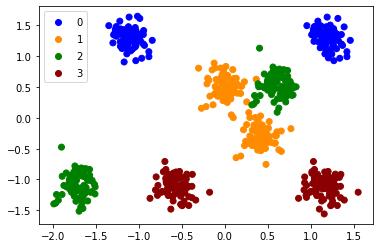

In [50]:
scatter = plt.scatter(x=X_train_nor[:, 0], y=X_train_nor[:, 1], c=y_train, cmap=our_cmap)
plt.legend(*scatter.legend_elements())

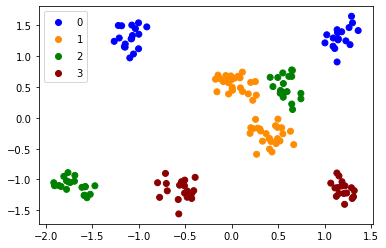

In [51]:
scatter = plt.scatter(x=X_test_nor[:, 0], y=X_test_nor[:, 1], c=y_test, cmap=our_cmap)
plt.legend(*scatter.legend_elements())

### SOM definition

As with normalized data has no sense a rectangular SOM, will use an squared one:

In [52]:
N_nor = int(A**0.5 + 1)
M_nor = N_nor

In [53]:
print(f"N={N_nor}, M={M_nor}")

N=12, M=12


### Training

#### On-line

In [54]:
[best_som_nor, best_eq_nor, best_et_nor] = eval_and_get_best_som(
    tries=5,
    data=X_train_nor,
    N=N_nor, M=M_nor, sigma=sigma, lr=lr, 
    iterations=iterations, batch=False)

In [55]:
print(f"Best on-line EQ: {best_eq_nor}\nBest on-line ET: {best_et_nor}")

Best on-line EQ: 0.05666652465557265
Best on-line ET: 0.021875


#### Batch

In [56]:
[batch_som_nor, batch_eq_nor, batch_et_nor] = eval_and_get_best_som(
    tries=1,
    data=X_train_nor,
    N=N_nor, M=M_nor, sigma=sigma, lr=lr, 
    iterations=iterations, batch=True)

In [57]:
print(f"Batch EQ: {batch_eq_nor}\nBatch ET: {batch_et_nor}")

Batch EQ: 0.05766790347728692
Batch ET: 0.021875


### U-matrix and class map plots

#### On-line

The below plot is the *on-line* SOM U-matrix representation using normalized data

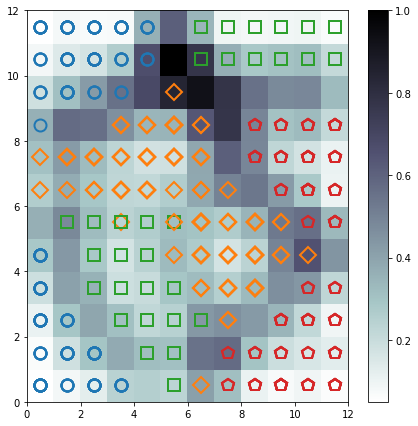

In [58]:
plot_distance_map(best_som_nor, N_nor, M_nor, X_train_nor, y_train)

This is the best *on-line* SOM class map using normalized data

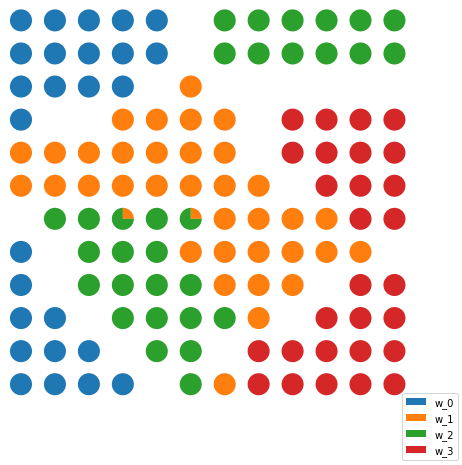

In [59]:
plot_class_map(best_som_nor, N_nor, M_nor, X_train_nor, y_train)

#### Batch

The below plot is the *batch* SOM U-matrix representation using normalized data

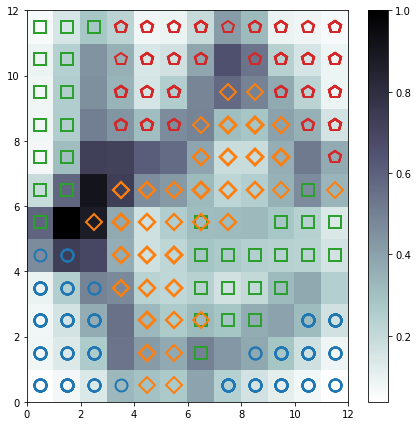

In [60]:
plot_distance_map(batch_som_nor, N_nor, M_nor, X_train_nor, y_train)

The plot below represents the batch SOM class map using normalized data.

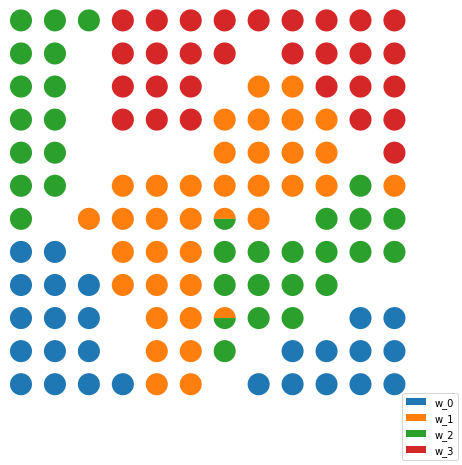

In [61]:
plot_class_map(batch_som_nor, N_nor, M_nor, X_train_nor, y_train)

### Confusion matrix and classification accuracy

#### On-line

In [62]:
y_pred_nor = classify(best_som_nor, X_test_nor, X_train_nor, y_train)

Confusion Matrix:

In [63]:
cm_nor = confusion_matrix(y_true=y_test, y_pred=y_pred_nor)
pretty_print_cm(cm_nor)

           Predict 0 Predict 1 Predict 2 Predict 3
Class 0:         35         0         0         0
Class 1:          0        49         2         0
Class 2:          0         0        39         0
Class 3:          0         0         0        35


Accuracy:

In [64]:
acc_ol_nor = accuracy_score(y_true=y_test, y_pred=y_pred_nor)
print(f"Accuracy: {acc_ol_nor}")

Accuracy: 0.9875


#### Batch

In [65]:
y_pred_nor = classify(batch_som_nor, X_test_nor, X_train_nor, y_train)

Confusion Matrix:

In [66]:
cm_nor = confusion_matrix(y_true=y_test, y_pred=y_pred_nor)
pretty_print_cm(cm_nor)

           Predict 0 Predict 1 Predict 2 Predict 3
Class 0:         35         0         0         0
Class 1:          0        49         2         0
Class 2:          0         0        39         0
Class 3:          0         0         0        35


Accuracy:

In [67]:
acc_bat_nor = accuracy_score(y_true=y_test, y_pred=y_pred_nor)
print(f"Accuracy: {acc_bat_nor}")

Accuracy: 0.9875


## Comentaris i conclusions

Hem definit dues geometries per a xarxes *SOM* seguint les guies de Kohonen. 
Per a les dades sense normalitzar, una xarxa rectangular de 16 x 8 neurones. 
I per a la versió de les dades ya normalitzades, una xarxa quadrada de 12 x 12 neurones.
Hem fet servir el mateix número d'iteracions recomanades (500 x número_de_neurones), 
tot i ésser una mica exagerada; 
el mateix valor de sigma (2) 
i també de tots els altres paràmetres 
com la funció que ens permet ponderar l'afectació
en els pesos de la pròpia neurona guanyadora 
i cada neurona veïna 
(en el nostre cas hem utilitzat una gaussiana).
Per tal d'inicialitzar els pesos hem fet servir *PCI*  en tots els casos.
Les proves fetes amb inicialitzacions de pesos 
a partir de mostres aleatòries ha donat resultats similars.

Pel que fa a la confecció dels mapes tant 
a les versions realitzades amb les dades no normalitzades, 
com amb les dades normalitzades, s'aprecia com en efecte
es manté la topologia
(a vegades amb una transformació especular en un sol eix o en ambdos eixos).
De fet els errors de topologia (ET) són molt baixos. 
També ho són els errors de quantificació (EQ)

A mode de resum, llistam els valors dels coeficients d'error:

In [68]:
print("Raw data:\n=========")
print(f"Best on-line EQ: {best_eq_raw}\nBest on-line ET: {best_et_raw}")
print(f"Batch EQ       : {batch_eq_raw}\nBatch ET       : {batch_et_raw}")
print("\nNormalized data:\n================")
print(f"Best on-line EQ: {best_eq_nor}\nBest on-line ET: {best_et_nor}")
print(f"Batch EQ       : {batch_eq_nor}\nBatch ET       : {batch_et_nor}")

Raw data:
Best on-line EQ: 0.0905980333773165
Best on-line ET: 0.0046875
Batch EQ       : 0.09161696868620062
Batch ET       : 0.0

Normalized data:
Best on-line EQ: 0.05666652465557265
Best on-line ET: 0.021875
Batch EQ       : 0.05766790347728692
Batch ET       : 0.021875


Pel que fa a faceta de les *SOM* com a classificadors, 
hem obtingut uns excel·lents resultats (superiors al 97% d'exactitud) 
tant amb les dades no normalitzades, com amb les normalitzades. 
A continuació hem llistat les quatre puntuacions de la mètrica *accuracy* obtinguda:

In [69]:
print("Raw test data accuracy:\n=======================")
print(f"Best on-line: {acc_ol_raw}")
print(f"Batch       : {acc_bat_raw}")
print("\nNormalized test data accuracy:\n==============================")
print(f"Best on-line: {acc_ol_nor}")
print(f"Batch       : {acc_bat_nor}")

Raw test data accuracy:
Best on-line: 1.0
Batch       : 0.99375

Normalized test data accuracy:
Best on-line: 0.9875
Batch       : 0.9875


Que les *SOM* tractades hagin tengut comportaments similars amb les dades originals
i la versió normalitzada, pensam que es pot explicar perquè en realitat els valors no normalitzats 
de cada una de les dues característiques, són comparables entre sí.

En definitiva ens sembla que en general les xarxes *SOM* 
són una bona eina per a la reducció de la dimensionalitat de les dades, 
adaptant-les a les dues o tres dimensions que sí podem percebre. 
Com a avantage afegit, pensam que presenten 
un cost computacional més baix que el d'una xarxa neuronal profunda.
Al capítol dels inconvenients consideram que si prescindim de les etiquetes,
distingir els elements de la classe $w_3$ centrats a (5, 0)
dels elements de la classe $w_1$ (taronja), requereix d'un cert entrenament
en l'interpretació del mapa de distàncies. 

Moltes de gràcies per tot.